In [1]:
import json
with open('heas_context_v1.json', 'r', encoding='utf-8') as f:
    records = json.load(f)
records = records[1:]
where_to_save = 'csv_files'

In [2]:
import re
from pymatgen.core import Composition
from script.normalize_value import normalize_value_with_unit
      

In [3]:
 
def extract_grain_size(record):
    unit_multiplier = {
        'nm': 1e-3,
        'µm': 1,
        'μm': 1,
        'um': 1,
        'mm': 1e3,
        'm': 1e6,
    }
    def normalized_unit_grain_size(unit_expr):
        pattern = re.compile(r'(µm|nm|μm|mm|um|m)', re.IGNORECASE)
        match = pattern.search(unit_expr)
        if match:
            return match.group(1)
        return None 
    grain_sizes = record['Record'].get('grain_size', [])
    if not grain_sizes:
        return
    if len(grain_sizes) > 1: # abandon multiple grain sizes for now
        return
    if len(grain_sizes) == 1:
        if isinstance(grain_sizes, list):
            value_unit = normalize_value_with_unit(grain_sizes[0]['grain_size'])
        else:
            value_unit = normalize_value_with_unit(grain_sizes['grain_size'])
        if value_unit is None:
            return
        value, unit_expr = value_unit
        unit = normalized_unit_grain_size(unit_expr)
        if unit in unit_multiplier:
            value_in_micrometer = value * unit_multiplier[unit]
            return value_in_micrometer
    return


def extract_yield_strength(record, type_: str):
    strengths = record['Record'].get('strength', [])
    if not strengths:
        return
    def normalized_unit_strength(unit_expr):
        pattern = re.compile(r'(pa|kpa|mpa|gpa|psi|ksi|n/?mm2|bar)', re.IGNORECASE)
        match = pattern.search(unit_expr or '')
        if not match:
            return None
        u = match.group(1).lower()
        if u in ('nmm2', 'n/mm2'):
            return 'mpa'
        return u

    unit_multiplier_strength = {
        'pa': 1e-6,
        'kpa': 1e-3,
        'mpa': 1.0,
        'gpa': 1e3,
        'psi': 0.00689476,
        'ksi': 6.89476,
        'bar': 0.1
    }

    t = []
    for s in strengths:
        if s.get('test_type') != type_:
            continue
        temperature, strain_rate, ys = s.get('temperature'), s.get('strain_rate'), s.get('ys')
        # if not all((temperature, strain_rate, ys)):
        if not all((temperature, ys)):
            continue
        temp_c = _normalize_temperature(temperature)
        sr = _normalize_strain_rate(strain_rate)
        # if temp_c is None or sr is None:
        if temp_c is None:
            continue
        vu = normalize_value_with_unit(ys)
        if not vu:
            continue
        val, unit_expr = vu
        unit = normalized_unit_strength(unit_expr)
        if unit and unit in unit_multiplier_strength:
            t.append((val * unit_multiplier_strength[unit], temp_c, sr))
            # t.append((val * unit_multiplier_strength[unit], temp_c))
    return t


def _normalize_temperature(temp):
    unit_multiplier_temp = {
        'c': 1.0,
        'k': -273.15,
        'f': -17.2222,
    }
    pattern = re.compile(r'(-?\d+\.?\d*)\s*(°?\s*[ckf])', re.IGNORECASE)
    match = pattern.search(temp)
    if match:
        value = float(match.group(1))
        unit = match.group(2).strip().lower().replace('°', '').replace(' ', '')
        if unit in unit_multiplier_temp:
            if unit == 'c':
                return value
            elif unit == 'k':
                return value + unit_multiplier_temp[unit]
            elif unit == 'f':
                return (value - 32) * 5.0/9.0
    if re.search(r'(room temperature|ambient)', temp, re.IGNORECASE):
        return 25.0
    return None

def _normalize_strain(strain):
    """
    Parse strain values from string format to decimal.
    Accepts formats like: "5%", "5 %", "0.03", "3%", etc.
    Returns strain as a decimal value (e.g., 5% -> 0.05)
    """
    pattern = re.compile(r'(-?\d+\.?\d*)\s*%?', re.IGNORECASE)
    match = pattern.search(strain)
    
    if match:
        value = float(match.group(1))
        
        # Check if percentage symbol is present
        if '%' in strain:
            return value
        else:
            # If no % symbol, assume it's already in decimal form
            # But check if value seems like it should be a percentage
            if value > 1.0:
                # Likely a percentage without the % symbol (e.g., "5" meaning 5%)
                return value * 100.0
            else:
                # Already in decimal form (e.g., "0.03")
                return value
    
    return None

def _normalize_strain_rate(sr):
    if sr is None:
        return None
    if isinstance(sr, (int, float)):
        return float(sr)
    s = str(sr).strip()
    # Normalize common multiplication signs
    s = s.replace('×', 'x').replace('·', 'e')
    # Capture plain numbers, scientific notation (1e-4) or "1 x 10^-4" forms
    pattern = re.compile(
        r'(?P<val>[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?|'      # 1, 1.0, 1e-4
        r'[+-]?\d+(?:\.\d+)?\s*[xX]\s*10\^?[+-]?\d+)'        # 1 x 10^-4
        , re.IGNORECASE)
    m = pattern.search(s)
    if not m:
        return None
    val = m.group('val')
    # Convert "1 x 10^-4" -> "1e-4"
    val = re.sub(r'([+-]?\d+(?:\.\d+)?)\s*[xX]\s*10\^?([+-]?\d+)', r'\1e\2', val)
    try:
        return float(val)
    except ValueError:
        return None

def extract_synthesis(record):
    synthesis = record['Record'].get('synthesis')
    if synthesis:
        steps = synthesis.get('steps')
        return steps
    return

def normalize_composition_string(comp_str: str):
    """
    Convert alloy notation like (CoCrFeNi)95Ti1Nb1Al3 to normalized form
    where each element has its atomic percentage explicitly stated.
    
    Args:
        comp_str: Alloy composition string with parentheses notation
        
    Returns:
        Normalized composition string with explicit atomic percentages
    """
    pattern_with_number = re.compile(r'\(([A-Z][a-z]?\d*)+\)(\d+(?:\.\d+)?)')
    new_comp_str = comp_str


    def secure_composition(comp_str) -> Composition:
        if re.search(r'^\d', comp_str):
            # Swap element and number to ensure correct parsing
            swap_pattern = re.compile(r'(\d+(?:\.\d+)?)([A-Z][a-z]?)')
            comp_str_swapped = re.sub(swap_pattern, r'\2\1', comp_str) 
            return Composition(comp_str_swapped)
        return Composition(comp_str)

    def composition_sum_to_100(comp: Composition) -> Composition:
        return Composition({
            el: round((num / comp.num_atoms) * 100, 3)
            for el, num in comp.items()
        })

    hyphen_p = re.compile(r'-|–')
    if re.search(hyphen_p, comp_str):
        return normalize_composition_string(comp_str.replace('-', '').replace('–', ''))

    if re.search(pattern_with_number, comp_str) is None:
        try:
            comp = secure_composition(comp_str)
            normalized_comp = composition_sum_to_100(comp)
            return normalized_comp.alphabetical_formula
        except Exception as e:
            return
    
    # Find all parenthesized groups with their multipliers
    matches = list(pattern_with_number.finditer(comp_str))
    
    # Process matches in reverse order to avoid index shifting issues
    for match in reversed(matches):
        try:
            full_match = match.group(0)  # e.g., "(CoCrFeNi)95"
            sub_comp_str = match.group(0).split(')')[0] + ')'  # e.g., "(CoCrFeNi)"
            multiplier = float(match.group(2))  # e.g., "95"
            
            # Parse the composition inside parentheses
            sub_comp = secure_composition(sub_comp_str)
            total_atoms = sub_comp.num_atoms
            
            # Calculate atomic percentage for each element
            normalized_comp = Composition({
                el: round((num / total_atoms) * multiplier, 3)
                for el, num in sub_comp.items()
            })
            # Format as string without extra spaces
            formatted_comp_str = normalized_comp.formula
            
            # Replace the parenthesized notation with normalized form
            new_comp_str = new_comp_str.replace(full_match, formatted_comp_str)
            
        except Exception as e:
            return
    
    try:
        new_comp = secure_composition(new_comp_str)
        return composition_sum_to_100(new_comp).alphabetical_formula
    except Exception as e:
        return
        
def extract_composition(record):
    composition = record['Record'].get('metadata', {}).get('composition')
    # only process at. % now, remove composites and wt. %
    # e.g., Fe42.26Ni27.5Co17.5Al10.5Ta2.2B0.04@at
    if composition and '@at' in composition:
        sections = composition.split('@at')
        if len(sections) > 1: # composites
            if sections[1]:
                return
        comp = sections[0]
        c = normalize_composition_string(comp)
        return c
    return

In [4]:
def extract_mechanical_properties(record, test_type: str):
    """
    Extract both yield strength and strain data from a record.
    Returns a list of tuples containing (yield_strength_mpa, temperature_c, strain_rate, strain_decimal)
    Any field can be None if not available.
    
    Args:
        record: The data record containing strength information
        test_type: The type of test (e.g., 'tensile', 'compression')
    
    Returns:
        List of tuples: [(ys_mpa, temp_c, strain_rate, strain), ...]
        Returns empty list if no valid data found
    """
    strengths = record['Record'].get('strength', [])
    if not strengths:
        return []
    
    def normalized_unit_strength(unit_expr):
        pattern = re.compile(r'(pa|kpa|mpa|gpa|psi|ksi|n/?mm2|bar)', re.IGNORECASE)
        match = pattern.search(unit_expr or '')
        if not match:
            return None
        u = match.group(1).lower()
        if u in ('nmm2', 'n/mm2'):
            return 'mpa'
        return u

    unit_multiplier_strength = {
        'pa': 1e-6,
        'kpa': 1e-3,
        'mpa': 1.0,
        'gpa': 1e3,
        'psi': 0.00689476,
        'ksi': 6.89476,
        'bar': 0.1
    }

    results = []
    for s in strengths:
        if s.get('test_type') != test_type:
            continue
        
        temperature = s.get('temperature')
        strain_rate = s.get('strain_rate')
        ys = s.get('ys')
        uts = s.get('uts')
        strain = s.get('strain')
        
        # Need at least temperature and either ys or strain
        if not temperature or not (ys or strain):
            continue
        
        # Normalize temperature
        temp_c = _normalize_temperature(temperature)
        if temp_c is None:
            continue
        
        # Normalize strain rate (can be None)
        sr = _normalize_strain_rate(strain_rate)
        
        # Normalize yield strength (can be None)
        ys_mpa = None
        if ys:
            vu = normalize_value_with_unit(ys)
            if vu:
                val, unit_expr = vu
                unit = normalized_unit_strength(unit_expr)
                if unit and unit in unit_multiplier_strength:
                    ys_mpa = val * unit_multiplier_strength[unit]
        
        # Normalize ultimate tensile strength (can be None)
        uts_mpa = None
        if uts:
            vu = normalize_value_with_unit(uts)
            if vu:
                val, unit_expr = vu
                unit = normalized_unit_strength(unit_expr)
                if unit and unit in unit_multiplier_strength:
                    uts_mpa = val * unit_multiplier_strength[unit]
        
        # Normalize strain (can be None)
        strain_decimal = None
        if strain:
            strain_decimal = _normalize_strain(strain)
        
        # Add to results if at least one mechanical property exists
        if ys_mpa is not None or strain_decimal is not None or uts_mpa is not None:
            results.append((ys_mpa, uts_mpa, temp_c, sr, strain_decimal))
    
    return results

In [5]:
records[0]

{'doi': '10.1016/j.jallcom.2021.159740',
 'Record': {'metadata': {'composition': 'NbTaW@at'},
  'strength': [{'ys': '1298 MPa',
    'uts': '1460 MPa',
    'strain': '16.2%',
    'temperature': 'room temperature',
    'strain_rate': None,
    'test_env': 'compressive, sample size Ф5 × 8 mm',
    'test_type': 'compressive'}],
  'phase': [{'phases': ['BCC'], 'test_env': None}],
  'synthesis': {'steps': [{'arc melting': {'power': '',
      'atmosphere': 'argon',
      'pressure': '',
      'crucible material': '',
      'electrode material': '',
      'number of remelts': '5'}}]}}}

In [6]:
from temp import strict_consensus_phases
import pandas as pd

def create_df_phase():
    list_dicts = []
    for record in records[:]:
        phases_list = record['Record'].get('phase', [])
        phases = strict_consensus_phases(phases_list)
        proc = extract_synthesis(record)
        comp = extract_composition(record)
        comp_raw = record['Record'].get('metadata', {}).get('composition')
        if not phases:
            continue
        list_dicts.append(
            {
                'composition': comp,
                'composition_raw': comp_raw,
                'phases': phases,
                'synthesis_steps': proc
            }
        )
        # for ys,temp, sr in ys_ts:
        # for ys, temp in ys_ts:
        #     list_dicts.append({
        #         'composition_raw': comp_raw,
        #         'composition': comp,
        #         'grain_size_um': gs,
        #         'yield_strength_mpa': ys,
        #         'temperature_c': temp,
        #         # 'strain_rate': sr,
        #         'synthesis_steps': proc
        #     })
    df = pd.DataFrame(list_dicts)
    return df

In [7]:
df_phase = create_df_phase()
df_phase = df_phase[df_phase.composition.notna()]
df_phase = df_phase[df_phase.composition.apply(lambda c: len(Composition(c).elements) >= 3)].reset_index(drop=True)

In [8]:
df_phase

,composition,composition_raw,phases,synthesis_steps
0,Nb33.333 Ta33.333 W33.333,NbTaW@at,[BCC],"[{'arc melting': {'power': '', 'atmosphere': '..."
1,Mo4.995 Nb31.668 Ta31.668 W31.668,(NbTaW)0.95Mo0.05@at,[BCC],"[{'arc melting': {'power': '', 'atmosphere': '..."
2,Mo15.015 Nb28.328 Ta28.328 W28.328,(NbTaW)0.85Mo0.15@at,[BCC],"[{'arc melting': {'power': '', 'atmosphere': '..."
3,Mo25 Nb25 Ta25 W25,(NbTaW)0.75Mo0.25@at,[BCC],"[{'arc melting': {'power': '', 'atmosphere': '..."
4,Co20 Cr40 Ni40,Co20Cr40Ni40@at,[FCC],"[{'arc melting': {'power': '', 'atmosphere': '..."
...,...,...,...,...
3904,Hf20 Nb20 Ti20 V20 Zr20,HfNbTiVZr@at,[BCC],None
3905,Mo20 Nb20 Ta20 V20 W20,MoNbTaVW@at,[BCC],None
3906,Mo25 Nb25 Ta25 W25,MoNbTaW@at,[BCC],None
3907,Nb20 Ti20 V40 Zr20,NbTiV2Zr@at,[BCC],None


In [9]:
df_phase.composition.nunique()

1808

In [10]:
TARGETS_ORDER = ["FCC", "BCC", "HCP", "Amorphous", "L12", "B2", "Laves", "IM"]
SS = ["FCC", "BCC", "HCP"]
IM = ["L12", "B2", "Laves", "IM"]
AM = ["Amorphous"]
def ss_im_based_classify(phases: list[str]):
    """classify phases into SS, IM or SS+IM based on phase list"""
    has_ss = any(phase in SS for phase in phases)
    has_im = any(phase in IM for phase in phases)
    if has_ss and has_im:
        return "SS+IM"
    elif has_ss:
        return "SS"
    elif has_im:
        return "IM"
    else:
        return None
def ss_based_classify(phases: list[str]):
    """classify phases into FCC, BCC, HCP or any mix of SS based on phase list"""
    for phase in phases:
        if phase not in SS:
            return None
    sorted_phases = sorted(phases, key=lambda x: SS.index(x)) # we don't consider order here
    return '+'.join(sorted_phases)
df_phase['phases_ss_im'] = df_phase['phases'].apply(ss_im_based_classify)
df_phase['phases_ss'] = df_phase['phases'].apply(ss_based_classify)

In [11]:
# remove same compositions with different phases
def resolve_conflict(target_column: str):
    group_by_composition = df_phase.groupby('composition')
    g_l = []
    for _, group in group_by_composition:
        phases_list = group[target_column].to_list()
        if len(phases_list) == 1:
            g_l.append(group.iloc[0])
        else:
            first = phases_list[0]
            all_same = all([first == other for other in phases_list[1:]]) 
            if all_same:
                g_l.append(group.iloc[0])
    df_phase_cleaned = pd.DataFrame(g_l)
    df_phase_cleaned = df_phase_cleaned[df_phase_cleaned[target_column].notna()].reset_index(drop=True)
    return df_phase_cleaned

In [12]:
df_phase_ss_cleaned = resolve_conflict('phases_ss')
df_phase_ss_im_cleaned = resolve_conflict('phases_ss_im')
df_phase_cleaned = resolve_conflict('phases')

In [13]:
df_phase_cleaned.composition.nunique()

1605

In [14]:
# df_phase_ss_cleaned.to_csv(f'{where_to_save}/df_phase_ss_cleaned.csv', index=False, columns=['composition', 'phases_ss'])
# df_phase_ss_im_cleaned.to_csv(f'{where_to_save}/df_phase_ss_im_cleaned.csv', index=False, columns=['composition', 'phases_ss_im'])
# df_phase_cleaned.to_csv(f'{where_to_save}/df_phase_cleaned.csv', index=False, columns=['composition', 'phases'])

In [15]:
df_phase_ss_cleaned.phases_ss.value_counts()

phases_ss
FCC            313
BCC            262
FCC+BCC        165
FCC+HCP         27
BCC+HCP          9
FCC+BCC+HCP      7
HCP              3
Name: count, dtype: int64

In [16]:
import pandas as pd
def create_df_strength(type_):
    list_dicts = []
    for record in records[:]:
        gs = extract_grain_size(record)
        ys_ts = extract_yield_strength(record, type_)
        proc = extract_synthesis(record)
        comp = extract_composition(record)
        comp_raw = record['Record'].get('metadata', {}).get('composition')
        if not ys_ts:
            continue
        for ys,temp, sr in ys_ts:
        # for ys, temp in ys_ts:
            list_dicts.append({
                'composition_raw': comp_raw,
                'composition': comp,
                'grain_size_um': gs,
                'yield_strength_mpa': ys,
                'temperature_c': temp,
                'strain_rate': sr,
                'synthesis_steps': proc
            })
    df = pd.DataFrame(list_dicts)
    return df

In [14]:
number_of_records = 0
valid_records = []
for record in records:
    r = record['Record']
    if r.get('strength', []):
        for s in r.get('strength', []):
            ys, uts, strain = s.get('ys'), s.get('uts'), s.get('strain')
            if ys or uts or strain:
                valid_records.append(record)
                number_of_records += 1
                break
    else:
        if r.get('phase', []):
            for phase in r.get('phase', []):
                phases = phase.get('phases', [])
                if phases:
                    valid_records.append(record)
                    number_of_records += 1
                    break

def return_valid_df():
    """
    Create a DataFrame containing mechanical properties including both 
    yield strength and strain data.
    
    Args:
        type_: Test type (e.g., 'tensile', 'compression')
    
    Returns:
        pd.DataFrame with columns for composition, grain size, yield strength, 
        strain, temperature, strain rate, and synthesis steps
    """
    list_dicts = []
    
    for record in valid_records[:]:
        comp = extract_composition(record)
        
        
        list_dicts.append({
            'composition': comp,
        })
    
    df = pd.DataFrame(list_dicts)
    return df
        
    

In [15]:
df_valid = return_valid_df()

In [18]:
df_valid.composition.nunique()

2039

In [9]:
import pandas as pd

def create_df_mechanical_properties(type_):
    """
    Create a DataFrame containing mechanical properties including both 
    yield strength and strain data.
    
    Args:
        type_: Test type (e.g., 'tensile', 'compression')
    
    Returns:
        pd.DataFrame with columns for composition, grain size, yield strength, 
        strain, temperature, strain rate, and synthesis steps
    """
    list_dicts = []
    
    for record in records[:]:
        gs = extract_grain_size(record)
        mech_props = extract_mechanical_properties(record, type_)
        proc = extract_synthesis(record)
        comp = extract_composition(record)
        comp_raw = record['Record'].get('metadata', {}).get('composition')
        
        if not mech_props:
            continue
        
        for ys, uts, temp, sr, strain in mech_props:
            list_dicts.append({
                'composition_raw': comp_raw,
                'composition': comp,
                'grain_size_um': gs,
                'yield_strength_mpa': ys,
                'ultimate_tensile_strength_mpa': uts,
                'strain': strain,
                'temperature_c': temp,
                'strain_rate': sr,
                'synthesis_steps': proc
            })
    
    df = pd.DataFrame(list_dicts)
    return df

In [10]:
df_mechanical_tensile = create_df_mechanical_properties('tensile')
df_mechanical_compressive = create_df_mechanical_properties('compressive')

In [11]:
df_mechanical_compressive

,composition_raw,composition,grain_size_um,yield_strength_mpa,ultimate_tensile_strength_mpa,strain,temperature_c,strain_rate,synthesis_steps
0,NbTaW@at,Nb33.333 Ta33.333 W33.333,NaN,1298.0,1460.0,16.2,25.0,NaN,"[{'arc melting': {'power': '', 'atmosphere': '..."
1,(NbTaW)0.95Mo0.05@at,Mo4.995 Nb31.668 Ta31.668 W31.668,NaN,1210.0,1252.0,8.3,25.0,NaN,"[{'arc melting': {'power': '', 'atmosphere': '..."
2,(NbTaW)0.85Mo0.15@at,Mo15.015 Nb28.328 Ta28.328 W28.328,NaN,1092.0,1119.0,6.5,25.0,NaN,"[{'arc melting': {'power': '', 'atmosphere': '..."
3,(NbTaW)0.75Mo0.25@at,Mo25 Nb25 Ta25 W25,NaN,1158.0,1194.0,7.7,25.0,NaN,"[{'arc melting': {'power': '', 'atmosphere': '..."
4,CrMnFeCoNi@at,Co20 Cr20 Fe20 Mn20 Ni20,0.4715,1200.0,NaN,45.0,25.0,0.001,[{'mechanical alloying': {'milling time': '25-...
...,...,...,...,...,...,...,...,...,...
2626,NbTiV2Zr@at,Nb20 Ti20 V40 Zr20,NaN,72.0,NaN,50.0,1000.0,NaN,None
2627,NbTiVZr@at,Nb25 Ti25 V25 Zr25,NaN,1105.0,NaN,50.0,25.0,NaN,None
2628,NbTiVZr@at,Nb25 Ti25 V25 Zr25,NaN,834.0,NaN,50.0,600.0,NaN,None
2629,NbTiVZr@at,Nb25 Ti25 V25 Zr25,NaN,187.0,NaN,50.0,800.0,NaN,None


In [12]:
df_mechanical_tensile

,composition_raw,composition,grain_size_um,yield_strength_mpa,ultimate_tensile_strength_mpa,strain,temperature_c,strain_rate,synthesis_steps
0,Co60Ni40@at,Co60 Ni40,3.1000,140.0,419.0,72.0,25.0,0.00083,"[{'arc melting': {'power': '', 'atmosphere': '..."
1,Co20Cr40Ni40@at,Co20 Cr40 Ni40,2.7900,375.0,685.0,72.0,25.0,0.00083,"[{'arc melting': {'power': '', 'atmosphere': '..."
2,CrMnFeCoNi@at,Co20 Cr20 Fe20 Mn20 Ni20,0.4715,1150.0,1200.0,7.8,25.0,0.00100,[{'mechanical alloying': {'milling time': '25-...
3,CrMnFeCoNi@at,Co20 Cr20 Fe20 Mn20 Ni20,0.4715,1150.0,1183.0,4.0,25.0,0.00100,[{'mechanical alloying': {'milling time': '25-...
4,CrMnFeCoNi@at,Co20 Cr20 Fe20 Mn20 Ni20,3.4250,400.0,700.0,60.0,25.0,0.00100,[{'spray-drying': {'particle size': '10-25 bcm...
...,...,...,...,...,...,...,...,...,...
3253,CoMnNi@at,Co33.333 Mn33.333 Ni33.333,NaN,231.0,653.0,38.0,25.0,NaN,None
3254,FeMnNi@at,Fe33.333 Mn33.333 Ni33.333,NaN,221.0,602.0,36.0,25.0,NaN,None
3255,CoCrFeNi@at,Co25 Cr25 Fe25 Ni25,NaN,274.0,708.0,39.0,25.0,NaN,None
3256,CoCrMnNi@at,Co25 Cr25 Mn25 Ni25,NaN,282.0,694.0,44.0,25.0,NaN,None


In [24]:
df_tensile = create_df_strength('tensile')
df_compressive = create_df_strength('compressive')

In [25]:
df_tensile.yield_strength_mpa.sort_values(ascending=False).head(15)

2362    45009.0
2364    40672.0
1802     2390.0
247      2310.0
952      2186.0
959      2126.0
2138     2126.0
2437     2112.0
1803     2110.0
774      2100.0
1426     2088.0
825      2000.0
2276     2000.0
823      2000.0
2494     1980.0
Name: yield_strength_mpa, dtype: float64

In [26]:
LSP_METHODS = ['arc melting', 'induction melting', 'lavitation melting']
permissible_methods = ['cooling', 'solidification', 'casting', 'quenching']
def filter_lsp(row):
    steps = row['synthesis_steps']
    if not steps:
        return False
    names = [list(step.keys())[0].lower() for step in steps]
    def is_equivalent(method_name, target_name):
        return method_name in target_name or target_name in method_name
    # can only have permissible methods + at least one LSP method
    if not any(is_equivalent(method, names[0]) for method in LSP_METHODS):
        return False
    names = names[1:]
    for name in names:
        if not any(is_equivalent(method, name) for method in permissible_methods):
            return False
    return True

def has_lsp(row):
    steps = row['synthesis_steps']
    if not steps:
        return False
    names = [list(step.keys())[0].lower() for step in steps]
    def is_equivalent(method_name, target_name):
        return method_name in target_name or target_name in method_name
    if any(is_equivalent(method, names[0]) for method in LSP_METHODS):
        return True
    return False

In [27]:
df_t_lsp = df_tensile[df_tensile.apply(filter_lsp, axis=1)].reset_index(drop=True)

In [17]:
file_name = 'lsp_strict.csv'

In [22]:
df_lsp_with_comp_rt_sr = df_t_lsp[df_t_lsp['composition'].notna() & (df_t_lsp['temperature_c'] == 25.0)].reset_index(drop=True)
# only contain composition has more than 3 elements and average on tensile if composition are same
df_lsp_with_comp_rt_sr = df_lsp_with_comp_rt_sr[df_lsp_with_comp_rt_sr['composition'].apply(
    lambda c: len(Composition(c).elements) >= 3
)].reset_index(drop=True)
# df_lsp_with_comp_rt_sr.groupby('composition')['yield_strength_mpa'].mean().reset_index().to_csv(f'{where_to_save}/{file_name}', index=False, columns=['composition', 'yield_strength_mpa'])

In [24]:
df_lsp_with_comp_rt_sr.yield_strength_mpa.describe()

count     235.000000
mean      562.067404
std       307.841425
min        43.930000
25%       308.750000
50%       489.000000
75%       777.000000
max      1409.000000
Name: yield_strength_mpa, dtype: float64

In [8]:
df_with_gf = df_tensile[df_tensile['grain_size_um'].notna() & df_tensile['composition'].notna() & (df_tensile['temperature_c'] == 25.0)].reset_index(drop=True)
df_with_gf = df_with_gf[df_with_gf['composition'].apply(
    lambda c: len(Composition(c).elements) >= 3
    )].reset_index(drop=True)

In [9]:
df_with_gf = df_with_gf[df_with_gf['yield_strength_mpa'] < 3000]

In [10]:
df_with_gf.yield_strength_mpa.describe()

count     614.000000
mean      650.272476
std       395.635773
min        16.000000
25%       320.250000
50%       564.500000
75%       899.750000
max      2088.000000
Name: yield_strength_mpa, dtype: float64

In [11]:
df_with_gf.groupby(['composition', 'grain_size_um'])['yield_strength_mpa'].mean().reset_index().to_csv(f'{where_to_save}/tensile_with_grain_size.csv', index=False, columns=['composition', 'grain_size_um', 'yield_strength_mpa'])

In [20]:
df_with_gf.composition.value_counts()

composition
Co20 Cr20 Fe20 Mn20 Ni20                                       92
Al6.977 Co23.256 Cr23.256 Fe23.256 Ni23.256                    33
Co25 Cr25 Fe25 Ni25                                            26
Al2.439 Co24.39 Cr24.39 Fe24.39 Ni24.39                        24
Al16.393 Co16.393 Cr16.393 Fe16.393 Ni34.426                   21
                                                               ..
Co9.5 Cr9.5 Fe62 Mn9.5 Ni9.5                                    1
Co8.25 Cr8.25 Fe67 Mn8.25 Ni8.25                                1
Co20 Cr14 Fe20 Mn20 Ni26                                        1
Nb9.97 Ta4.98 Ti42.51 Zr42.54                                   1
Al3.517 Co23.447 Cr23.447 Fe23.447 Ni23.447 Ta0.352 Ti2.345     1
Name: count, Length: 230, dtype: int64

/var/folders/hn/w1znd6n125g0ff5tjdfnf5880000gn/T/ipykernel_71035/4176042701.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_strain_tensile['Type'] = 'Tensile'
/var/folders/hn/w1znd6n125g0ff5tjdfnf5880000gn/T/ipykernel_71035/4176042701.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_strain_compressive['Type'] = 'Compressive'
/var/folders/hn/w1znd6n125g0ff5tjdfnf5880000gn/T/ipykernel_71035/4176042701.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will

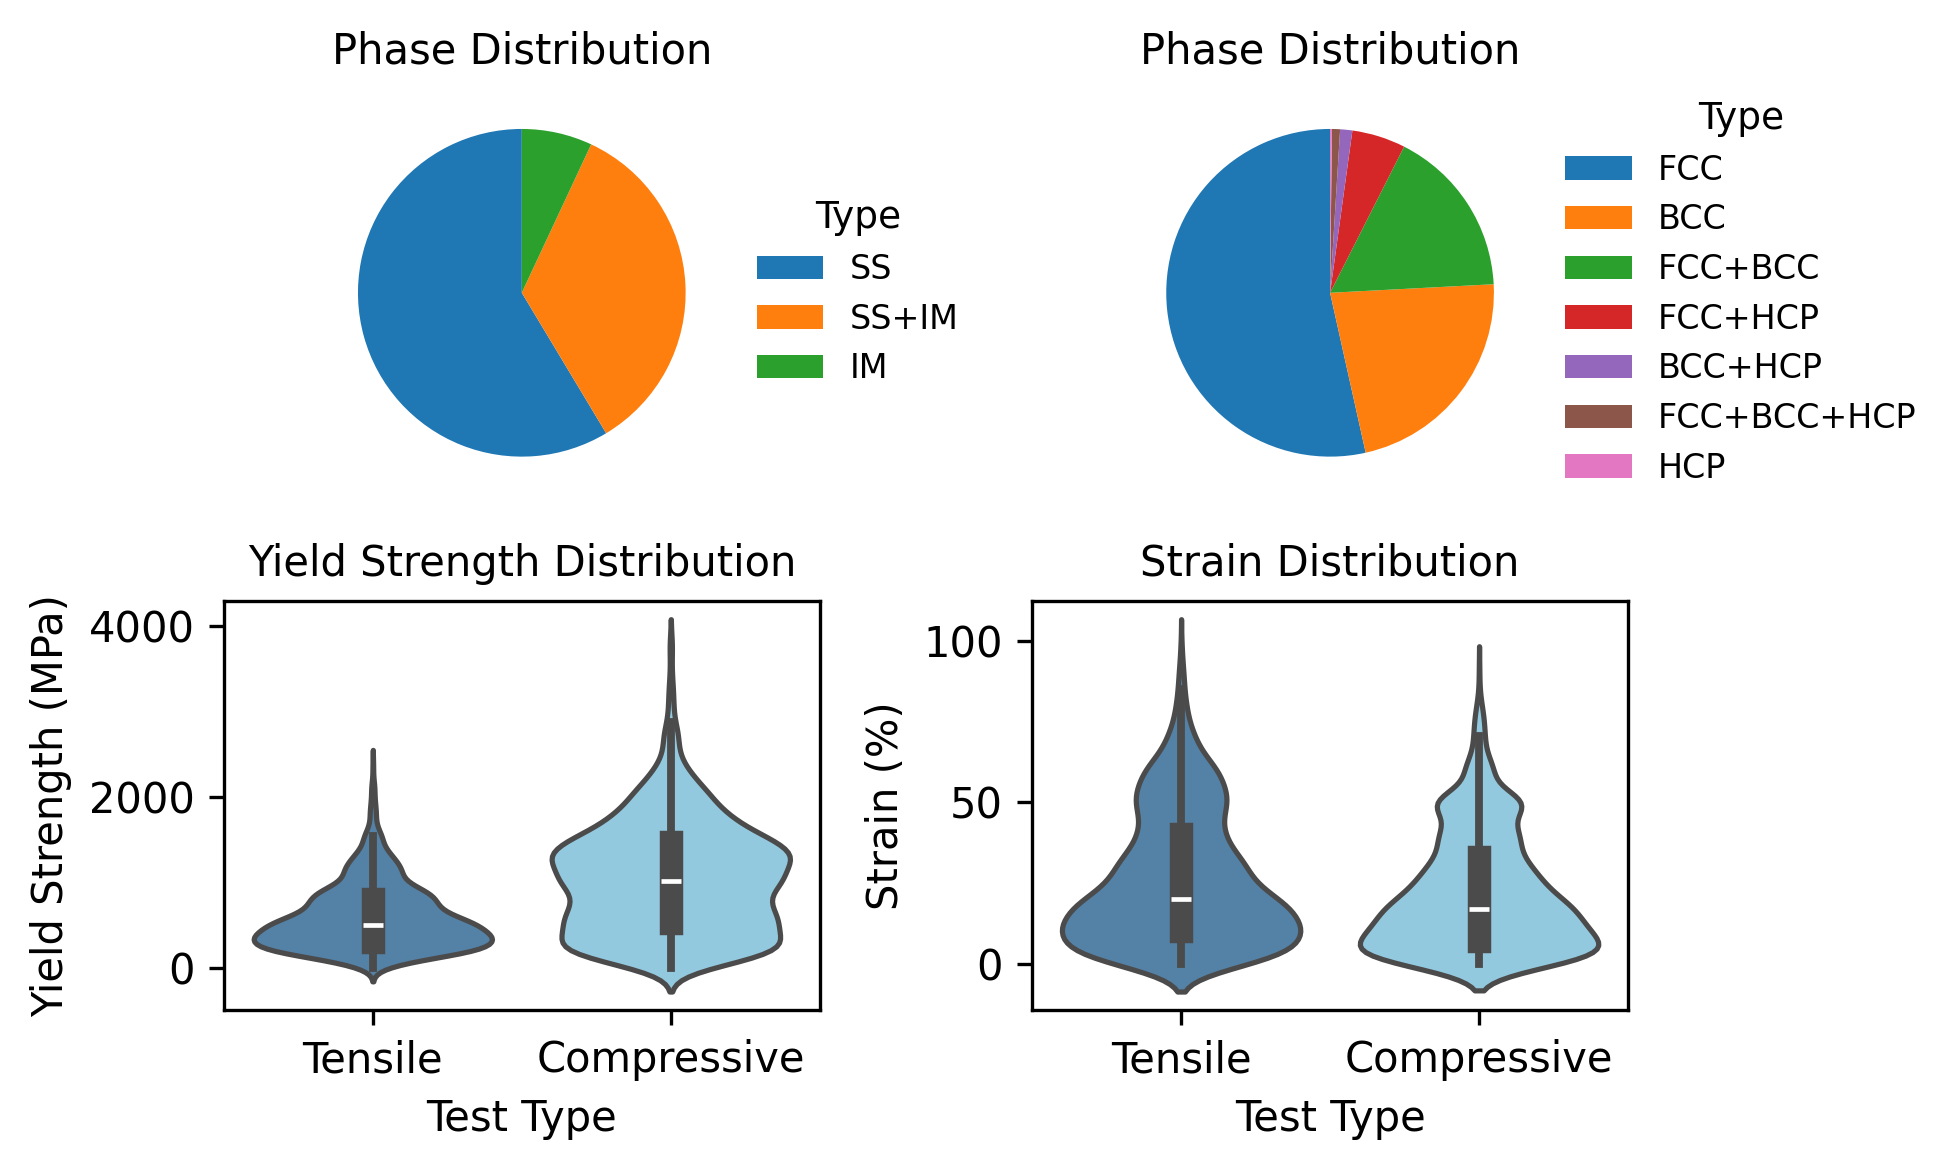

In [35]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns


def is_rt(t):
    t_ = int(float(t))
    if 20 < t_ < 30:
        return True
    return False


valid_ys_tensile = df_mechanical_tensile.loc[df_mechanical_tensile[(df_mechanical_tensile.yield_strength_mpa<4000) & (df_mechanical_tensile.yield_strength_mpa>0)].apply(lambda x: is_rt(x.temperature_c), axis=1).index]
valid_ys_compressive = df_mechanical_compressive.loc[df_mechanical_compressive[(df_mechanical_compressive.yield_strength_mpa<4000) & (df_mechanical_compressive.yield_strength_mpa>0)].apply(lambda x: is_rt(x.temperature_c), axis=1).index]
valid_ys_tensile['Type'] = 'Tensile'
valid_ys_compressive['Type'] = 'Compressive'
combined_data = pd.concat([valid_ys_tensile, valid_ys_compressive])

valid_strain_tensile = df_mechanical_tensile.loc[
    (df_mechanical_tensile['strain'] < 100) & 
    df_mechanical_tensile['strain'].notna() & 
    df_mechanical_tensile.apply(lambda x: is_rt(x['temperature_c']), axis=1)
]

valid_strain_compressive = df_mechanical_compressive.loc[
    (df_mechanical_compressive['strain'] < 100) & 
    df_mechanical_compressive['strain'].notna() & 
    df_mechanical_compressive.apply(lambda x: is_rt(x['temperature_c']), axis=1)
]
valid_strain_tensile['Type'] = 'Tensile'
valid_strain_compressive['Type'] = 'Compressive'
combined_strain_data = pd.concat([valid_strain_tensile, valid_strain_compressive])


# ss = df.apply(cls_phase_solidsolution, axis=1).value_counts()
# ss_im = df.apply(cls_phase_ssim, axis=1).value_counts()
ss = df_phase.phases_ss.value_counts()
ss_im = df_phase.phases_ss_im.value_counts()


# --- Combined 2x2 Figure: Top row = phase pie charts, Bottom row = violin plots ---
fig, axes = plt.subplots(2, 2, figsize=(6.5, 4), dpi=300)


# Top left: Pie chart for ss_im
wedges2, texts2 = axes[0, 0].pie(
    ss_im.values,
    labels=None,
    autopct=None,
    startangle=90,
    textprops={'fontsize': 8}
)
axes[0, 0].set_title('Phase Distribution', fontsize=10)
axes[0, 0].legend(wedges2, ss_im.index, title="Type", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8, title_fontsize=9, frameon=False)

# Top right: Pie chart for ss
wedges1, texts1 = axes[0, 1].pie(
    ss.values,
    labels=None,
    autopct=None,
    startangle=90,
    textprops={'fontsize': 8}
)
axes[0, 1].set_title('Phase Distribution', fontsize=10)
axes[0, 1].legend(wedges1, ss.index, title="Type", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8, title_fontsize=9, frameon=False)

# Bottom left: Yield Strength violin plot
sns.violinplot(data=combined_data, x='Type', y='yield_strength_mpa', palette=['steelblue', 'skyblue'], ax=axes[1, 0])
axes[1, 0].set_ylabel('Yield Strength (MPa)')
axes[1, 0].set_xlabel('Test Type')
axes[1, 0].set_title('Yield Strength Distribution', fontsize=10)


# Bottom right: Strain violin plot with more contrasting colors
sns.violinplot(data=combined_strain_data, x='Type', y='strain', palette=['steelblue', 'skyblue'], ax=axes[1, 1])
axes[1, 1].set_ylabel('Strain (%)')
axes[1, 1].set_xlabel('Test Type')
axes[1, 1].set_title('Strain Distribution', fontsize=10)

plt.tight_layout()
plt.savefig('phase_strength_strain_2x2.png', dpi=300, bbox_inches='tight')
plt.show()




